# The Lindblad equation

We consider the Hamiltonian

$$
    H(r, \theta, p_r, p_\theta) = p_r\, \mu(r) + \Vert p \Vert_{g}
$$

where

$$
    \mu(r) = \delta \sin 2r, \quad 
    \Vert p \Vert_{g} =  \sqrt{ p_r^2 + \frac{p_\theta^2}{m_\lambda^2(r)} }, \quad
    m_\lambda^2(r) = \frac{\sin^2 r}{1 - \lambda \sin^2 r}
$$

and where $\delta$ and $\lambda$ are constants. 
We will fix $\delta > 1$ (strong Zermelo case) and $\lambda = 4/5$.
Along the geodesics, we have $H+p^0 = 0$. The parameter $p^0$ is constant equal to $-1$ (hyperbolic), $0$ (abnormal) or $1$ (elliptic).

**Remark.** We can parameterize the geodesics by the norm of the initial convector, setting $\Vert{p_0}\Vert_g = 1$. 
This amounts to parameterize by the initial angle $\alpha_0$:
$$
    p_r = \sin \alpha_0, \quad p_\theta = m_\lambda(r) \cos \alpha_0.
$$
In that case, the hyperbolic geodeics are given by
$$
    p_r\, \mu(r) + 1 = \sin(\alpha_0)\, \delta \sin(2r) + 1 > 0.
$$

## Packages

In [1]:
import sys
sys.path.insert(1, '../')
#
import math
import numpy as np              # scientific computing tools
import wrappers                 # for compilation of Fortran Hamiltonian codes
import geometry2d.database
import geometry2d.conjugate
import geometry2d.errors
import geometry2d.geodesic
import geometry2d.plottings
import geometry2d.problem
import geometry2d.splitting
import geometry2d.utils
import geometry2d.wavefront
import matplotlib.pyplot as plt # for plots
%matplotlib inline

In [2]:
#
color_hyperbolic = 'red'
color_elliptic   = 'blue'
color_abnormal   = 'green'
color_cut_locus  = 'black'
color_conjugate  = 'magenta'
#
color_strong_domain_2d = 'lightblue'
color_strong_domain_3d = 'blue'

## Fortran Hamiltonian code

In [3]:
# print Fortran code of the Hamiltonian: print hfun.f90 file
with open('hfun.f90', 'r') as f:
    print(f.read())

! Lindblad
subroutine hfun(x, p, d, h)

    double precision, intent(in)  :: x(2), p(2), d
    double precision, intent(out) :: h

    ! local variables
    double precision :: r, th, pr, pth
    double precision :: l, m2, mu

    r   = x(1)
    th  = x(2)

    pr  = p(1)
    pth = p(2)

    l   = 4d0/5d0
    m2  = sin(r)**2/(1d0-l*sin(r)**2)
    mu  = d*sin(2*r)

    h   = mu*pr + sqrt(pr**2 + pth**2/m2)

end subroutine hfun


## Initializations

In [4]:
def initialize(d, r0):

    # Parameters
    #d  = -1.25        # strong Zermelo case
    #r0 = np.pi/2.0 #+ 3.0*np.pi/8.0 # initial azimuth
    θ0 = 0.0        # initial latitude
    t0 = 0.0        # initial time

    name = 'lindblad_strong' # name of the problem

    # Initialize data
    data_file = 'data_lindblad_strong.json'
    restart   = False # restart or not the computations
    data      = geometry2d.database.Data({'name': name,
                        't0': t0, 
                        'r0': r0, 
                        'θ0': θ0, 
                        'd': d}, data_file, restart)

    # Initial point
    q0 = np.array([r0, θ0])

    # Hamiltonian and derivatives up to order 3
    H = wrappers.hamiltonian(d, compile=False, display=False)

    # The Riemannian metric associated to the Zermelo problem
    def g(q):
        λ  = 4.0/5.0
        r  = q[0] 
        g1 = 1.0
        g2 = np.sqrt(np.sin(r)**2/(1.0-λ*np.sin(r)**2))
        return g1, g2

    # problem
    prob = geometry2d.problem.GeometryProblem2D(name, H, g, t0, q0, data, steps_for_geodesics=200)
    
    return prob

In [5]:
# function to plot the domain of strong current between two angles r1 and r2
def plot_2d_domain(fig, r1, r2):
    # from r to phi
    def phi(r):
        return r - np.pi/2.0
    ph1 = phi(r1)
    ph2 = phi(r2)
    # plot the domain: a 2d surface
    ax = fig.axes[0]
    x  = np.linspace(-np.pi, np.pi, 100)
    y1 = np.ones_like(x)*ph1
    y2 = np.ones_like(x)*ph2
    ax.fill_between(x, y1, y2, color=color_strong_domain_2d, alpha=0.5)
    return fig  

In [6]:
def plot_3d_domain(fig, r1, r2):
    # from r to phi
    def phi(r):
        return r - np.pi/2.0
    φ1 = phi(r1)
    φ2 = phi(r2)
    # plot the domain: a 2d surface between the parallel of latitude φ1 and φ2 on the sphere
    ax = fig.axes[0]
    # 
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(φ1, φ2, 100)
    x = np.outer(np.cos(u), np.cos(v))
    y = np.outer(np.sin(u), np.cos(v))
    z = np.outer(np.ones(np.size(u)), np.sin(v))
    #
    ax.plot_surface(x, y, z, color=color_strong_domain_3d, alpha=0.5)
    return fig

## Parameterization of the geodesics

In [7]:
# we parameterize ||p(0)|| = 1 by the angle α0
# the norm being given by the metric g: p(0) = (sin(α0)*g1, cos(α0)*g2) = (sin(α0), cos(α0)*g2), since g1 = 1
# get the values of α0 for which h = pr mu(r) + 1 > 0
#
# first get the values of α for which h = pr mu(r) + 1 = 0
def mu(r, d):
    return d*np.sin(2*r)

def pr(α):
    return np.sin(α)

def h(r, α, d):
    return pr(α)*mu(r, d) + 1.0

def α0(r, d):
    return np.arcsin(-1.0/mu(r, d))

# get the values of α0 for which h = pr mu(r) + 1 > 0
def α_hyperbolique_1(r, d):
    m = mu(r, d)
    if abs(m) > 1.0:
        α = α0(r, d) # between -pi/2 and pi/2
        if α > 0.0:
            return np.pi - α
        else:
            return α
    else:
        return 0.0

def α_hyperbolique_2(r, d):
    m = mu(r, d)
    if abs(m) > 1.0:
        α = α0(r, d) # between -pi/2 and pi/2
        if α > 0.0:
            return 2.0*np.pi + α
        else:
            return np.pi - α
    else:
        return 2.0*np.pi

def α_hyperbolique_span(r, d, *, N=20):
    α1 = α_hyperbolique_1(r, d)
    print('α1 = ', α1)
    α2 = α_hyperbolique_2(r, d)
    print('α2 = ', α2)
    return np.linspace(α1, α2, N)

# get the values of α0 for which h = pr mu(r) + 1 < 0
def α_elliptique_1(r, d):
    m = mu(r, d)
    if abs(m) > 1.0:
        α = α0(r, d) # between -pi/2 and pi/2
        if α > 0.0:
            return α
        else:
            return np.pi - α
    else:
        # raise an error: there is no elliptic domain
        raise geometry2d.errors.ArgumentValueError('There is no elliptic domain for this value of d')
    
def α_elliptique_2(r, d):
    m = mu(r, d)
    if abs(m) > 1.0:
        α = α0(r, d) # between -pi/2 and pi/2
        if α > 0.0:
            return np.pi - α
        else:
            return α + 2.0*np.pi
    else:
        # raise an error: there is no elliptic domain
        raise geometry2d.errors.ArgumentValueError('There is no elliptic domain for this value of d')
    
def α_elliptique_span(r, d, *, N=20):
    α1 = α_elliptique_1(r, d)
    print('α1 = ', α1)
    α2 = α_elliptique_2(r, d)
    print('α2 = ', α2)
    return np.linspace(α1, α2, N)

## Make plots

In [8]:
def make_plots(r0, d, prob, *, cameras=[{'azimuth': 160, 'elevation': -10}]):

    # North hemisphere
    rp1 = math.asin(1/np.abs(d))/2.0
    rp2 = (math.pi - math.asin(1/np.abs(d))) / 2.0

    # South hemisphere
    rm1 = (-math.asin(1/np.abs(d)) % (2*np.pi) )/2.0
    rm2 = (math.pi + math.asin(1/np.abs(d))) / 2.0

    # Geodesics
    geodesic = geometry2d.geodesic.Geodesic(prob)

    #
    αspan_hyperbolique = α_hyperbolique_span(r0, d, N=31)

    #
    fig2d = geodesic.plot(alphas=αspan_hyperbolique, tf=4, length=1.0, 
                          view=geometry2d.plottings.Coords.PLANE, figsize=(4,4), color=color_hyperbolic)
    fig2d = plot_2d_domain(fig2d, rp1, rp2)
    fig2d = plot_2d_domain(fig2d, rm1, rm2)

    # cameras is a list of dictionaries containing azimuth and elevetion angles
    figs3d = []
    for cam in cameras:
        azimuth = cam['azimuth']
        elevation = cam['elevation']
        fig3d = geodesic.plot(alphas=αspan_hyperbolique, tf=4, length=1.0,
            view=geometry2d.plottings.Coords.SPHERE, azimuth=azimuth, elevation=elevation, figsize=(3,3),
            color=color_hyperbolic)
        fig3d = plot_3d_domain(fig3d, rp1, rp2)
        fig3d = plot_3d_domain(fig3d, rm1, rm2)
        figs3d.append(fig3d)
    
    return fig2d, figs3d

## Example 1

In [9]:
d = 1.25
r0 = np.pi/2.0
prob = initialize(d, r0)
fig2d, figs3d = make_plots(r0, d, prob)

α1 =  0.0
α2 =  6.283185307179586


<Figure size 640x480 with 0 Axes>

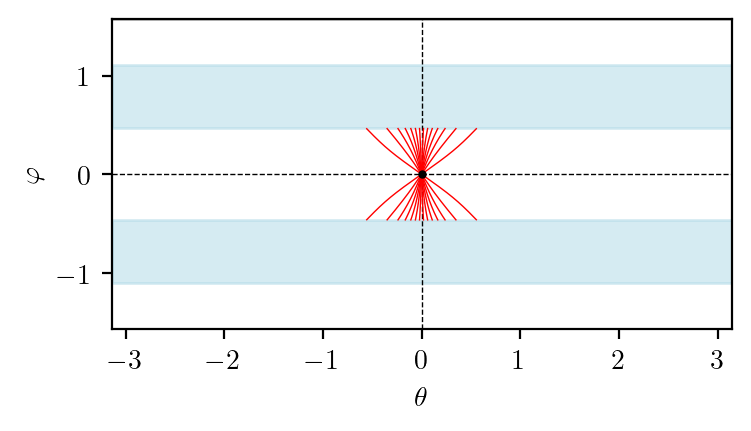

In [10]:
fig2d

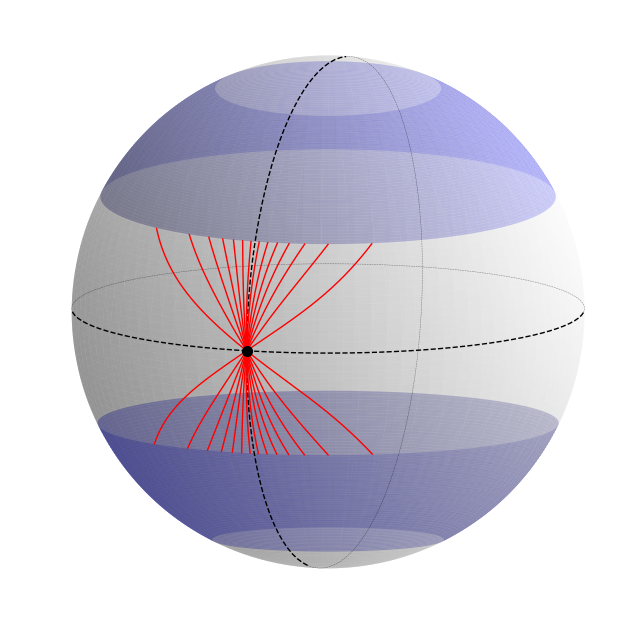

In [11]:
figs3d[0]

# Example 2

In [12]:
d = 1.25
r0 = np.pi/2.0 + 2.0*np.pi/8.0
prob = initialize(d, r0)
fig2d, figs3d = make_plots(r0, d, prob)

# add Elliptic geodesics
αspan_elliptic = α_elliptique_span(r0, d, N=20)
geodesic = geometry2d.geodesic.Geodesic(prob)
fig3d_with_elliptic = geodesic.plot(alphas=αspan_elliptic, tf=np.pi, \
    view=geometry2d.plottings.Coords.SPHERE, figure=figs3d[0], color=color_elliptic)

α1 =  2.214297435588181
α2 =  7.2104805251811985
α1 =  0.9272952180016123
α2 =  2.214297435588181


<Figure size 640x480 with 0 Axes>

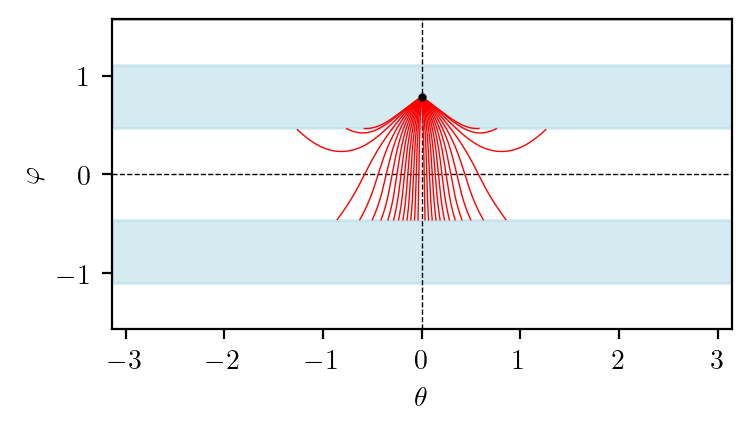

In [13]:
fig2d

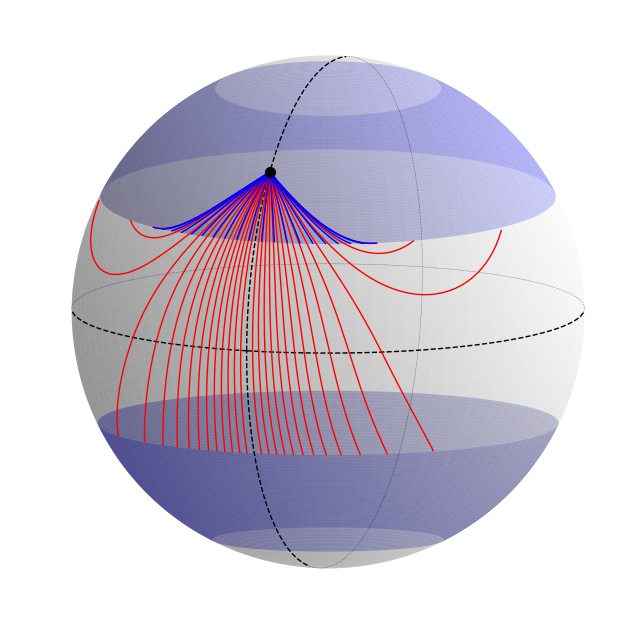

In [14]:
figs3d[0]

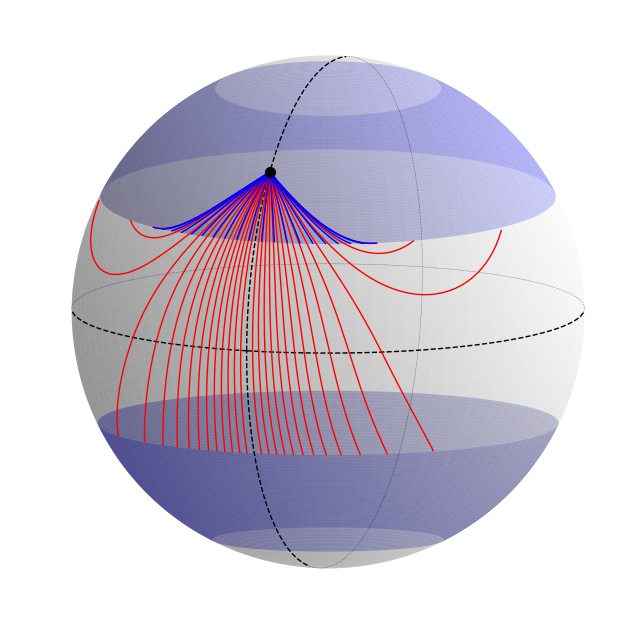

In [15]:
fig3d_with_elliptic

# Example 3

In [16]:
d = 1.25
r0 = np.pi/2.0 + 3.0*np.pi/8.0
prob = initialize(d, r0)
fig2d, figs3d = make_plots(r0, d, prob)

α1 =  0.0
α2 =  6.283185307179586


<Figure size 640x480 with 0 Axes>

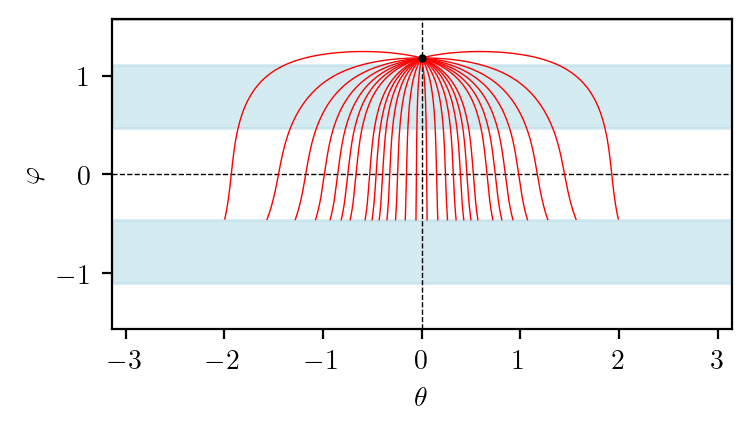

In [17]:
fig2d

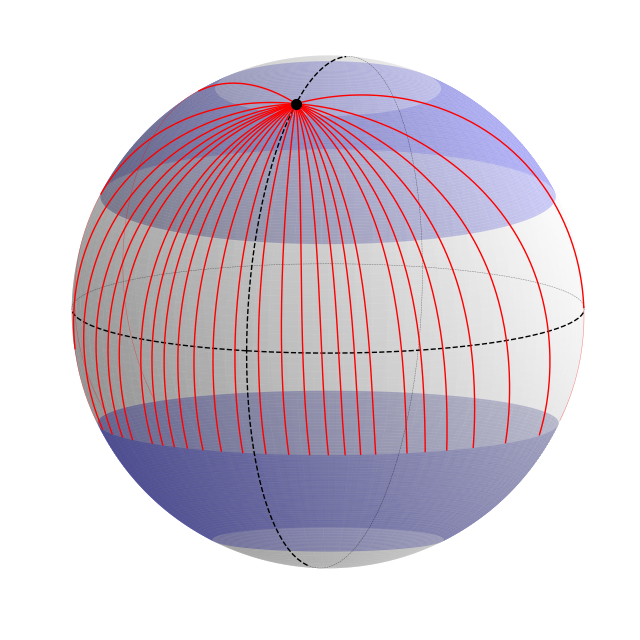

In [18]:
figs3d[0]

# Example 4

In [19]:
d = -1.25
r0 = np.pi/2.0
prob = initialize(d, r0)
cameras = [{'azimuth': 160, 'elevation': -10}, {'azimuth': 20, 'elevation': -25}]
fig2d, figs3d = make_plots(r0, d, prob, cameras=cameras)

α1 =  0.0
α2 =  6.283185307179586


<Figure size 640x480 with 0 Axes>

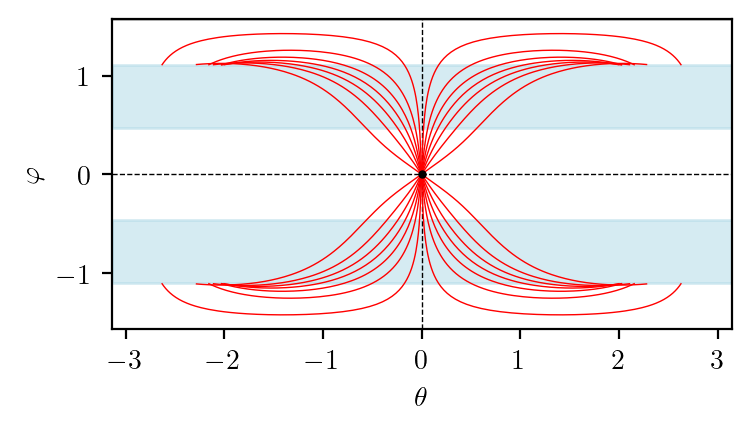

In [20]:
fig2d

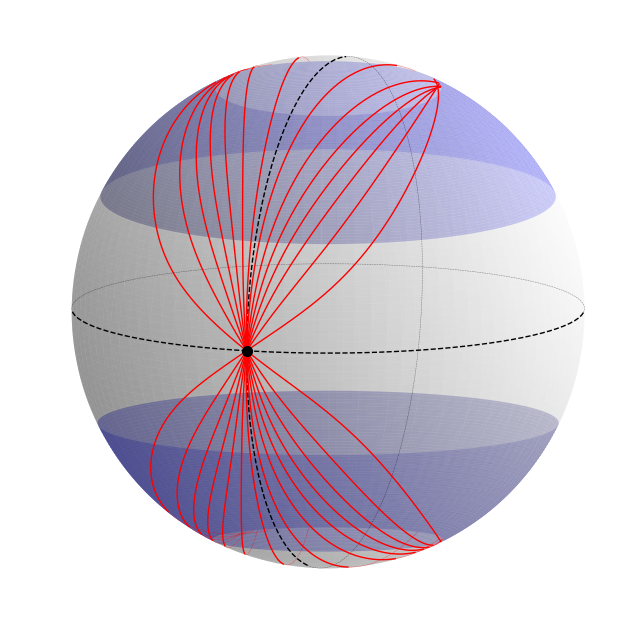

In [21]:
figs3d[0]

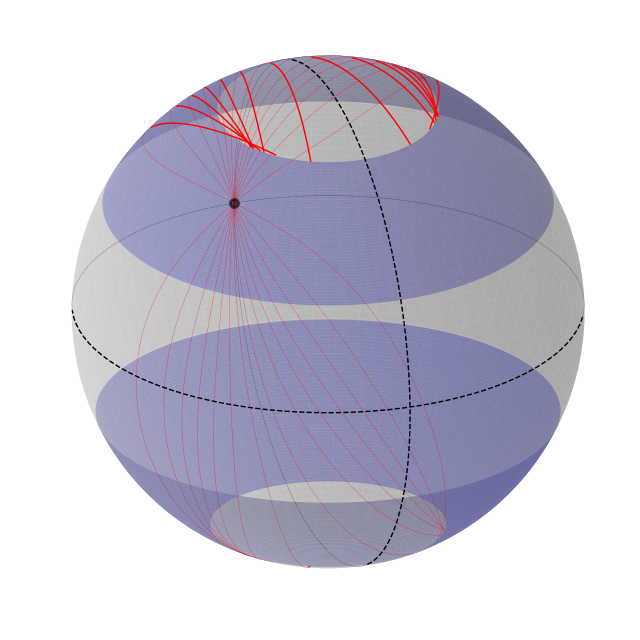

In [22]:
figs3d[1]

# Example 5

In [23]:
d = -1.25
r0 = np.pi/2.0 + 2.0*np.pi/8.0
prob = initialize(d, r0)
cameras = [{'azimuth': 160, 'elevation': -10}, {'azimuth': 160, 'elevation': -40}]
fig2d, figs3d = make_plots(r0, d, prob, cameras=cameras)

α1 =  -0.9272952180016123
α2 =  4.068887871591405


<Figure size 640x480 with 0 Axes>

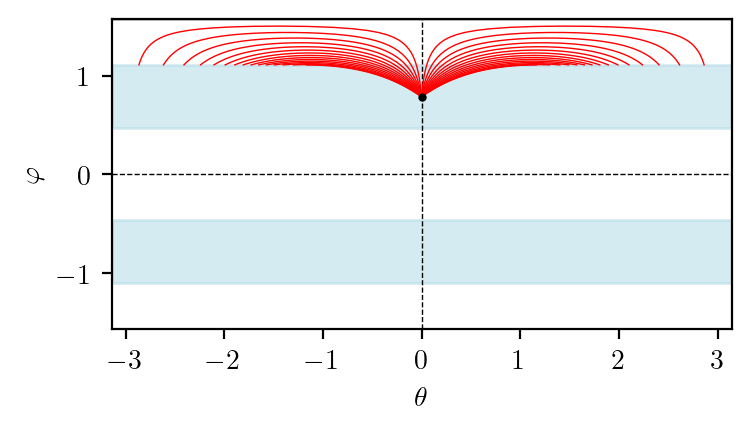

In [24]:
fig2d

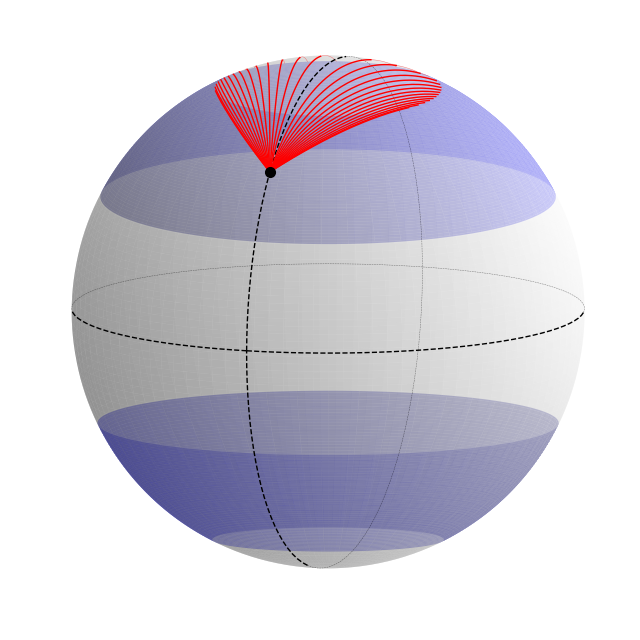

In [25]:
figs3d[0]

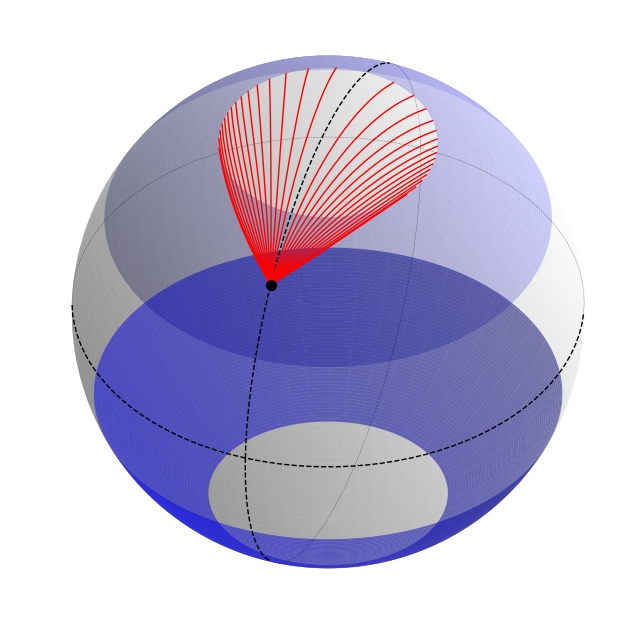

In [26]:
figs3d[1]

# Example 6

In [27]:
d = -1.25
r0 = np.pi/2.0 + 3.0*np.pi/8.0
prob = initialize(d, r0)
cameras = [{'azimuth': 160, 'elevation': -10}, {'azimuth': 160, 'elevation': -40}]
fig2d, figs3d = make_plots(r0, d, prob, cameras=cameras)

α1 =  0.0
α2 =  6.283185307179586


<Figure size 640x480 with 0 Axes>

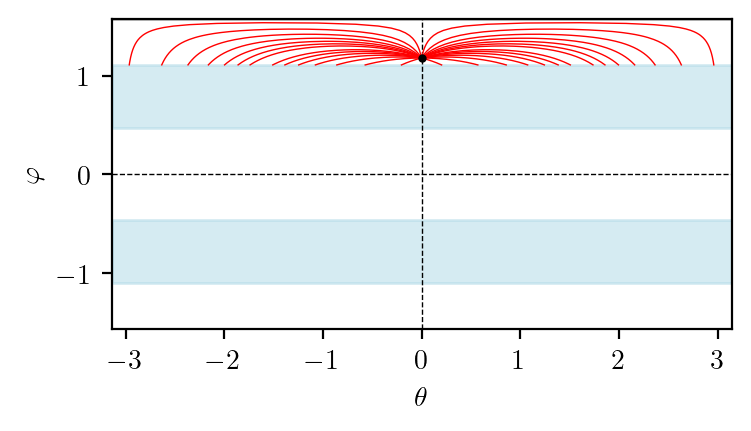

In [28]:
fig2d

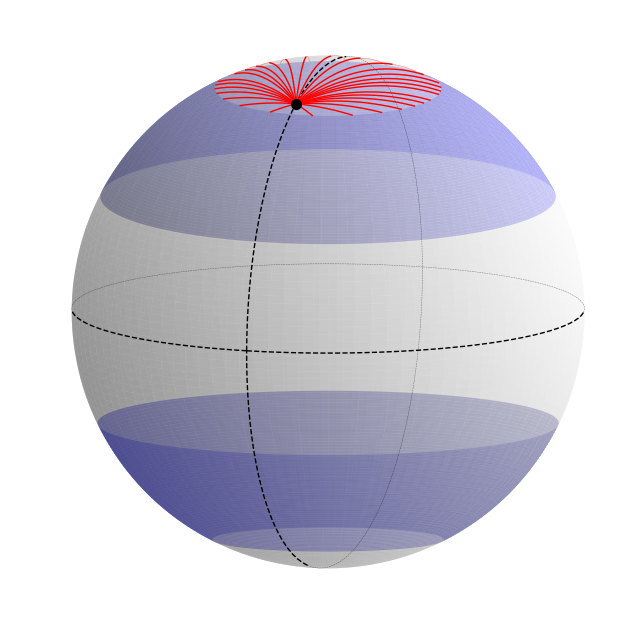

In [29]:
figs3d[0]

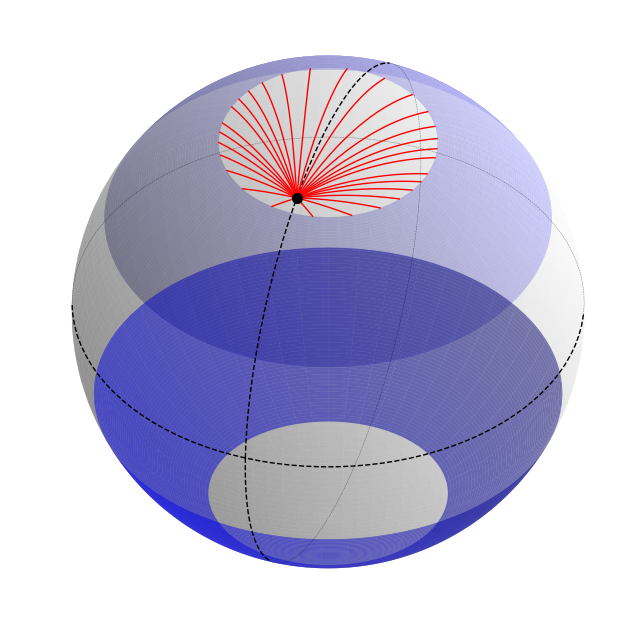

In [30]:
figs3d[1]